#### Exercises Solution

#### 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
  - For consistency, the dataset should have 1000 samples and a random_state=42.
  - Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [2]:
from sklearn.datasets import make_moons


# Make 1000 samples
n_samples = 1000

# Create moons
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise
                    random_state=42) # keep random state so we get the same values

In [3]:
#viewing first 5 x and y values
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]

First 5 y labels:
[1 1 1 1 0]


In [7]:
# Make DataFrame of moon data
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


In [8]:
#from above, each pair of X features (X1 and X2) has a label (y) value of either 0 or 1. so its a bin classifi. prob.
# Check values in each class
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

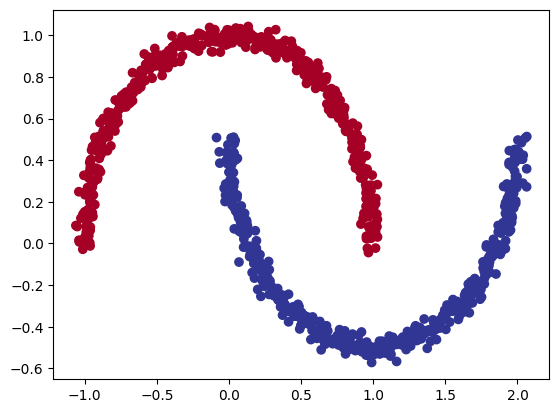

In [9]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [10]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [11]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [-0.00933187  0.39098105] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [12]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#### 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
 - Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [14]:
#Setting up device agnostic code (so our model can run on CPU or GPU if it's available)
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# Build model with non-linear activation function
from torch import nn
class MoonModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = MoonModelV2().to(device)
print(model_0)

MoonModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


#### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [16]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

#### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
- To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [17]:
#accuracy
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [18]:
# Fit the model
torch.manual_seed(42)
epochs = 1100

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71596, Accuracy: 50.00% | Test Loss: 0.71410, Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.70603, Accuracy: 50.00% | Test Loss: 0.70516, Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.69862, Accuracy: 50.00% | Test Loss: 0.69857, Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69234, Accuracy: 50.00% | Test Loss: 0.69278, Test Accuracy: 50.00%
Epoch: 40 | Loss: 0.68501, Accuracy: 50.00% | Test Loss: 0.68602, Test Accuracy: 50.00%
Epoch: 50 | Loss: 0.67582, Accuracy: 50.00% | Test Loss: 0.67760, Test Accuracy: 50.00%
Epoch: 60 | Loss: 0.66364, Accuracy: 60.75% | Test Loss: 0.66629, Test Accuracy: 60.00%
Epoch: 70 | Loss: 0.64683, Accuracy: 69.38% | Test Loss: 0.65058, Test Accuracy: 67.00%
Epoch: 80 | Loss: 0.62369, Accuracy: 74.88% | Test Loss: 0.62889, Test Accuracy: 71.00%
Epoch: 90 | Loss: 0.59316, Accuracy: 78.25% | Test Loss: 0.60041, Test Accuracy: 74.50%
Epoch: 100 | Loss: 0.55780, Accuracy: 80.75% | Test Loss: 0.56750, Test Accuracy: 77.00%
Epoch: 110 | Loss: 0.52093, Accu

#### 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function

In [20]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [21]:
#import the helper_functions.py script from the Learn PyTorch for Deep Learning repo
#which contains a helpful function called plot_decision_boundary()
#which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.
#We'll also import plot_predictions()


import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [22]:

from helper_functions import plot_predictions, plot_decision_boundary

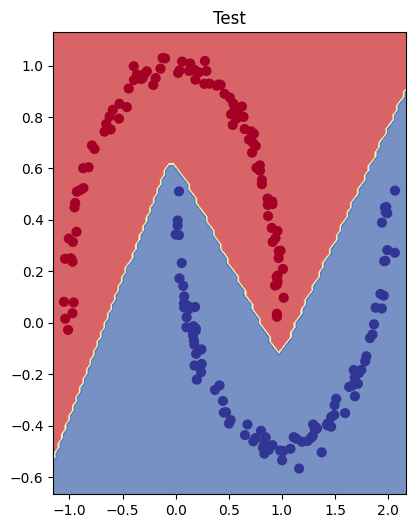

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 6))
#plt.subplot(1, 2, 1)
#plt.title("Train")
#plot_decision_boundary(model_0, X_train, y_train) # no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) # model_0 = has non-linearity

#### 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch. Feel free to reference the ML cheatsheet website for the formula.

In [24]:
# Create a toy tensor (similar to the data going into our model(s)) we just created this data to replicate the tanh act function
A = torch.arange(-15, 15, 0.5, dtype=torch.float32)
A

tensor([-15.0000, -14.5000, -14.0000, -13.5000, -13.0000, -12.5000, -12.0000,
        -11.5000, -11.0000, -10.5000, -10.0000,  -9.5000,  -9.0000,  -8.5000,
         -8.0000,  -7.5000,  -7.0000,  -6.5000,  -6.0000,  -5.5000,  -5.0000,
         -4.5000,  -4.0000,  -3.5000,  -3.0000,  -2.5000,  -2.0000,  -1.5000,
         -1.0000,  -0.5000,   0.0000,   0.5000,   1.0000,   1.5000,   2.0000,
          2.5000,   3.0000,   3.5000,   4.0000,   4.5000,   5.0000,   5.5000,
          6.0000,   6.5000,   7.0000,   7.5000,   8.0000,   8.5000,   9.0000,
          9.5000,  10.0000,  10.5000,  11.0000,  11.5000,  12.0000,  12.5000,
         13.0000,  13.5000,  14.0000,  14.5000])

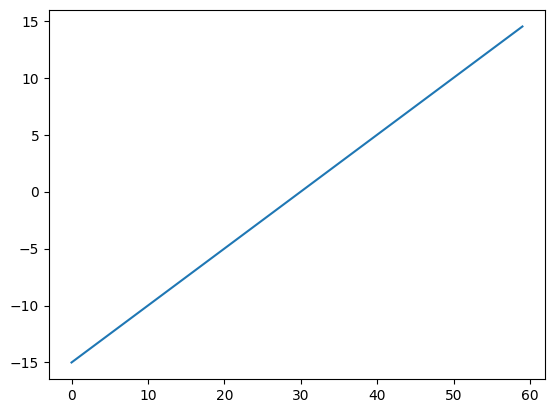

In [25]:
# Visualize the toy tensor
plt.plot(A);

In [26]:
# A straight line, nice.

#Now let's see how the tanh activation function influences it.

#Tanh(x)=tanh(x)=
#exp(x)+exp(−x)
#exp(x)−exp(−x)
def tanhfunction(x):
  result = (torch.exp(x) - torch.exp(-x))/ (torch.exp(x) + torch.exp(-x))
  return result

#testing
tanhfunction(A)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9998, -0.9993, -0.9982,
        -0.9951, -0.9866, -0.9640, -0.9051, -0.7616, -0.4621,  0.0000,  0.4621,
         0.7616,  0.9051,  0.9640,  0.9866,  0.9951,  0.9982,  0.9993,  0.9998,
         0.9999,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000])

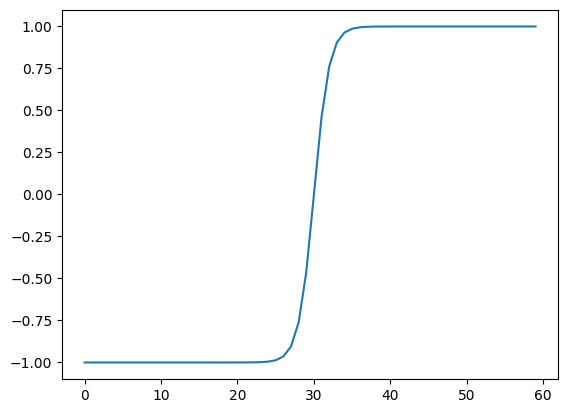

In [27]:
# Plot sigmoid activated toy tensor
plt.plot(tanhfunction(A));

#### 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
- Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
- Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
- Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
- Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

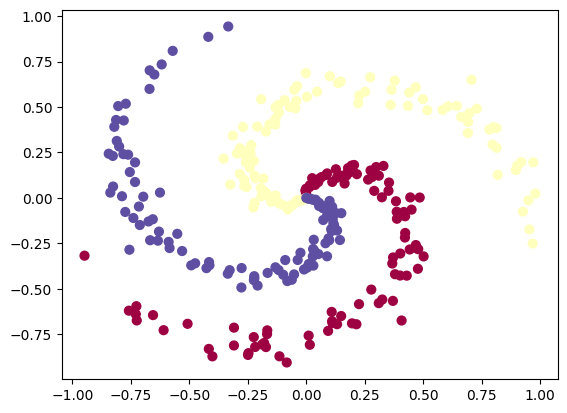

In [30]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [29]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [31]:
# Turn data into tensors
X_spiral = torch.from_numpy(X).type(torch.float)
y_spiral = torch.from_numpy(y).type(torch.LongTensor)
print(X_spiral[:5], y_spiral[:5])


tensor([[ 0.0000,  0.0000],
        [ 0.0013,  0.0100],
        [-0.0015,  0.0201],
        [-0.0009,  0.0303],
        [-0.0040,  0.0402]]) tensor([0, 0, 0, 0, 0])


In [32]:
X_spiral_train, X_spiral_test, y_spiral_train, y_spiral_test = train_test_split(X_spiral,
    y_spiral,
    test_size=0.2,
    random_state=42)

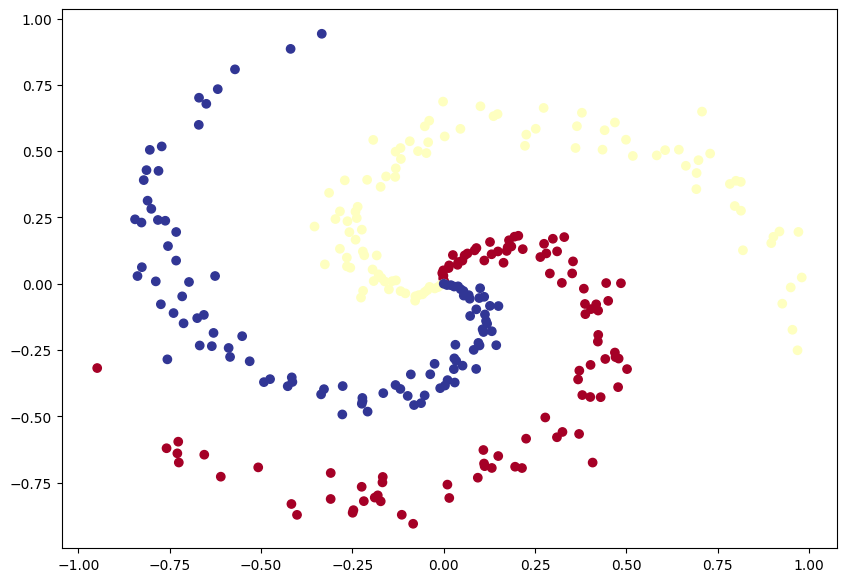

In [33]:
#Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_spiral[:, 0], X_spiral[:, 1], c=y_spiral, cmap=plt.cm.RdYlBu);

In [34]:
from torch import nn

# Build model
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_1 = SpiralModel(input_features=D,
                    output_features=K,
                    hidden_units=8).to(device)
model_1

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [45]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                            lr=0.05) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [36]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_1(X_spiral_train.to(device))[:5]

tensor([[-0.0963, -0.2587, -0.1165],
        [-0.2132, -0.2553, -0.2449],
        [-0.1172, -0.3102, -0.1470],
        [-0.3285, -0.3334, -0.3833],
        [-0.2681, -0.3718, -0.3223]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [37]:
# How many elements in a single prediction sample?
model_1(X_spiral_train.to(device))[0].shape, 3

(torch.Size([3]), 3)

In [38]:
# Make prediction logits with model
y_logits = model_1(X_spiral_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1165, -0.3007, -0.1448],
        [ 0.0594, -0.2913,  0.0504],
        [-0.1138, -0.3722, -0.1522],
        [-0.1252, -0.3131, -0.1562],
        [-0.1114, -0.2584, -0.1331]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3567, 0.2967, 0.3467],
        [0.3710, 0.2613, 0.3677],
        [0.3657, 0.2824, 0.3519],
        [0.3574, 0.2962, 0.3465],
        [0.3519, 0.3038, 0.3443]], device='cuda:0', grad_fn=<SliceBackward0>)


In [39]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [40]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3567, 0.2967, 0.3467], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [47]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_spiral_train, y_spiral_train = X_spiral_train.to(device), y_spiral_train.to(device)
X_spiral_test, y_spiral_test = X_spiral_test.to(device), y_spiral_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_spiral_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_spiral_train)
    acc = accuracy_fn(y_true=y_spiral_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_1(X_spiral_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_spiral_test)
      test_acc = accuracy_fn(y_true=y_spiral_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71281, Acc: 55.00% | Test Loss: 0.86458, Test Acc: 43.33%
Epoch: 10 | Loss: 0.71277, Acc: 55.42% | Test Loss: 0.86568, Test Acc: 43.33%
Epoch: 20 | Loss: 0.71277, Acc: 55.42% | Test Loss: 0.86484, Test Acc: 43.33%
Epoch: 30 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86539, Test Acc: 43.33%
Epoch: 40 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86508, Test Acc: 43.33%
Epoch: 50 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86524, Test Acc: 43.33%
Epoch: 60 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86517, Test Acc: 43.33%
Epoch: 70 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86520, Test Acc: 43.33%
Epoch: 80 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86519, Test Acc: 43.33%
Epoch: 90 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86519, Test Acc: 43.33%
Epoch: 100 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86518, Test Acc: 43.33%
Epoch: 110 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86519, Test Acc: 43.33%
Epoch: 120 | Loss: 0.71276, Acc: 55.42% | Test Loss: 0.86519, T

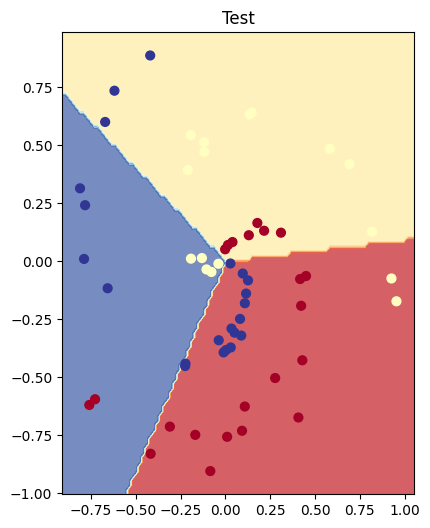

In [48]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10, 6))
#plt.subplot(1, 2, 1)
#plt.title("Train")
#plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_spiral_test, y_spiral_test)